In [1]:
import easylab_new2 as lab
import numpy as np
%matplotlib inline

In [2]:
x = lab.Var("x", lab.decimal_var_type(2))
y = lab.Var("y", lab.decimal_var_type(2))
z = lab.Var("z", lab.decimal_var_type(2), metadata={"source": "test"})

assert x.matches(x)
assert x.matches(...)
assert x.matches("*")
assert x.matches("x")
assert not x.matches(y)
assert not x.matches("y")

assert x.sub(1).matches(x.sub(1)) # Match by label comparison
assert x.sub(1).matches("x_1")
assert not x.sub(1).matches(x)
assert not x.sub(1).matches(x.sub(2))

assert x.matches("label: x")
assert x.matches("type: decimal(prec=2)")

assert z.matches("metadata: source: test")
assert not z.matches("metadata: source: notest")

In [3]:
record = lab.Record({x: 1, y: 2, z.sub(1): 3, z.sub(2): 4, z.sub(3): 5})
print(record)

{
    x = 1.00,
    y = 2.00,
    z_1 = 3.00,
    z_2 = 4.00,
    z_3 = 5.00
}


In [4]:
# Mutate record
record[x] = 2
print(record)

{
    x = 2.00,
    y = 2.00,
    z_1 = 3.00,
    z_2 = 4.00,
    z_3 = 5.00
}


In [5]:
assert not record.matches(x.eq(1))
assert record.matches(x.eq(2))
assert record.matches(z.sub(2).eq(4))

assert record.matches(x > 1)
assert record.matches(x < 3)
assert not record.matches(x > 2)

# and
assert record.matches(x.eq(2) & y.eq(2))
assert not record.matches(x.eq(2) & y.eq(3))
# or
assert record.matches(x.eq(3) | y.eq(2))
# not
assert record.matches(~x.eq(3))

In [6]:
# Copy record
record2 = record.copy()
record2[y] = "42"
del record2[z.sub(2)]
print(record2)

assert record != record2

# Check that the original record is unchanged by comparing the records
print(record.compare(record2))

{ x = 2.00, y = 42.00, z_1 = 3.00, z_3 = 5.00 }
{ compare(z_2) = 4.00 ↔, compare(y) = 2.00 ↔ 42.00 }


In [7]:
print(record & record2)

{ x = 2.00, y = 2.00, z_1 = 3.00, z_3 = 5.00 }


In [8]:
# Computed
xy = lab.Computed("xy", x * y)

print(xy.value_type)

assert xy.type.value_type is float # Check type inference

assert xy(4, 3) == 12
assert xy.matches(xy)

# Record with computed
assert record[xy] == 4

<class 'float'>


In [9]:
data = lab.ListData([record, record2])
print(data)

[ {
    x = 2.00,
    y = 2.00,
    z_1 = 3.00,
    z_2 = 4.00,
    z_3 = 5.00
}, { x = 2.00, y = 42.00, z_1 = 3.00, z_3 = 5.00 } ]


In [10]:
record = data.where(y.eq(42)).extract(lab.Record)

In [11]:
# Totzeit example

# infer all variables
totzeit = lab.load_data("totzeit.csv")
print(totzeit)
inferred_vars = totzeit.get_vars("metadata: source: inferred")
print(inferred_vars)

[
    { I [mA] = 0, R [Hz] = 2773 }
    { I [mA] = 0, R [Hz] = 4105 }
    { I [mA] = 0, R [Hz] = 5204 }
    { I [mA] = 0, R [Hz] = 6292 }
    { I [mA] = 0, R [Hz] = 7298 }
    ...13 more records (18 total)
]
[I [mA], R [Hz]]


In [12]:
# infer some variables
I = lab.Var("I", lab.PhysicalValue)
totzeit = lab.load_data("totzeit.csv", [I, "infer"])
print(totzeit)

[
    { I = 0.01, R [Hz] = 2773 }
    { I = 0.02, R [Hz] = 4105 }
    { I = 0.03, R [Hz] = 5204 }
    { I = 0.04, R [Hz] = 6292 }
    { I = 0.05, R [Hz] = 7298 }
    ...13 more records (18 total)
]


In [13]:
# infer no variables
R = lab.Var("R", lab.PhysicalValue)
totzeit = lab.load_data("totzeit.csv", [I, R])
print(totzeit)

[
    { I = 0.01, R = 2773.0 }
    { I = 0.02, R = 4105.0 }
    { I = 0.03, R = 5204.0 }
    { I = 0.04, R = 6292.0 }
    { I = 0.05, R = 7298.0 }
    ...13 more records (18 total)
]


In [14]:
U = lab.Computed("U", I * R)
totzeit.add(U)
# totzeit.plot(U, R)

In [15]:
totzeit.inspect()

DataInspector(children=(Text(value='I', continuous_update=False, description='x-axis:'), GraphInput(children=(…

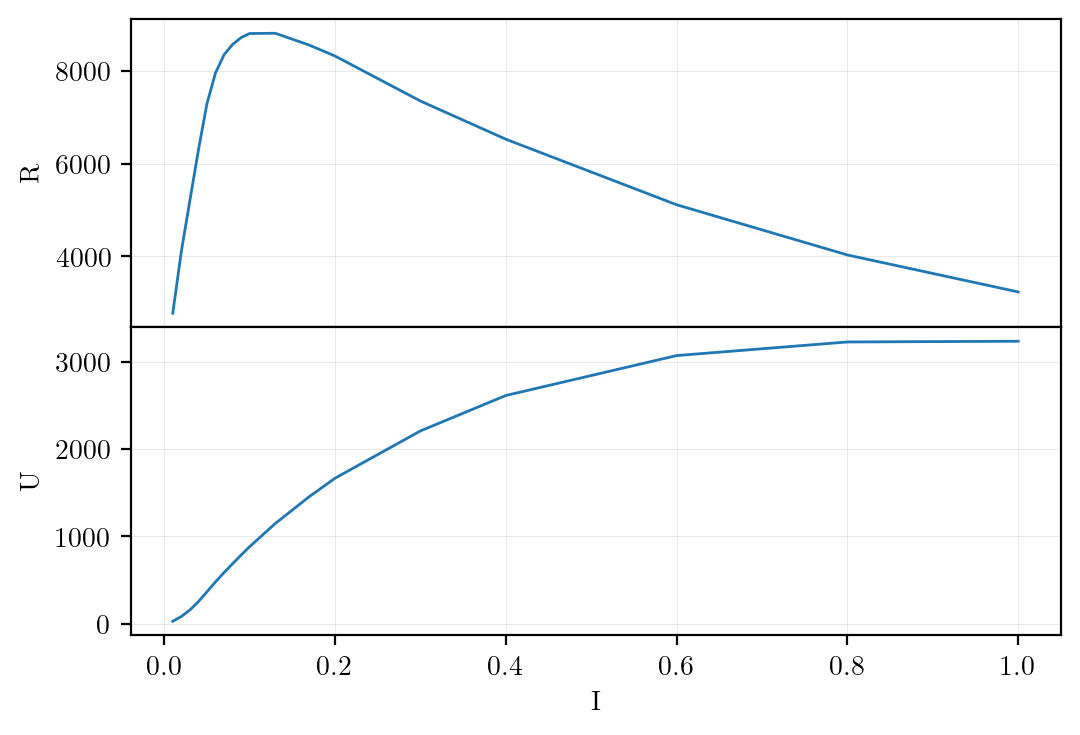

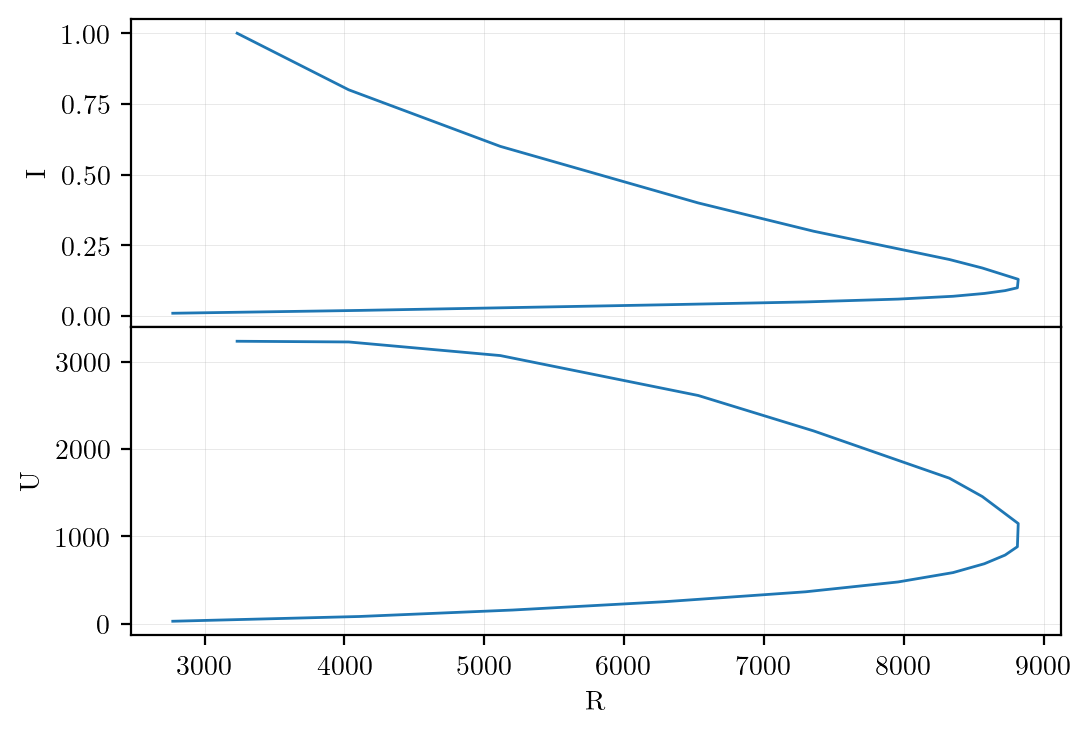

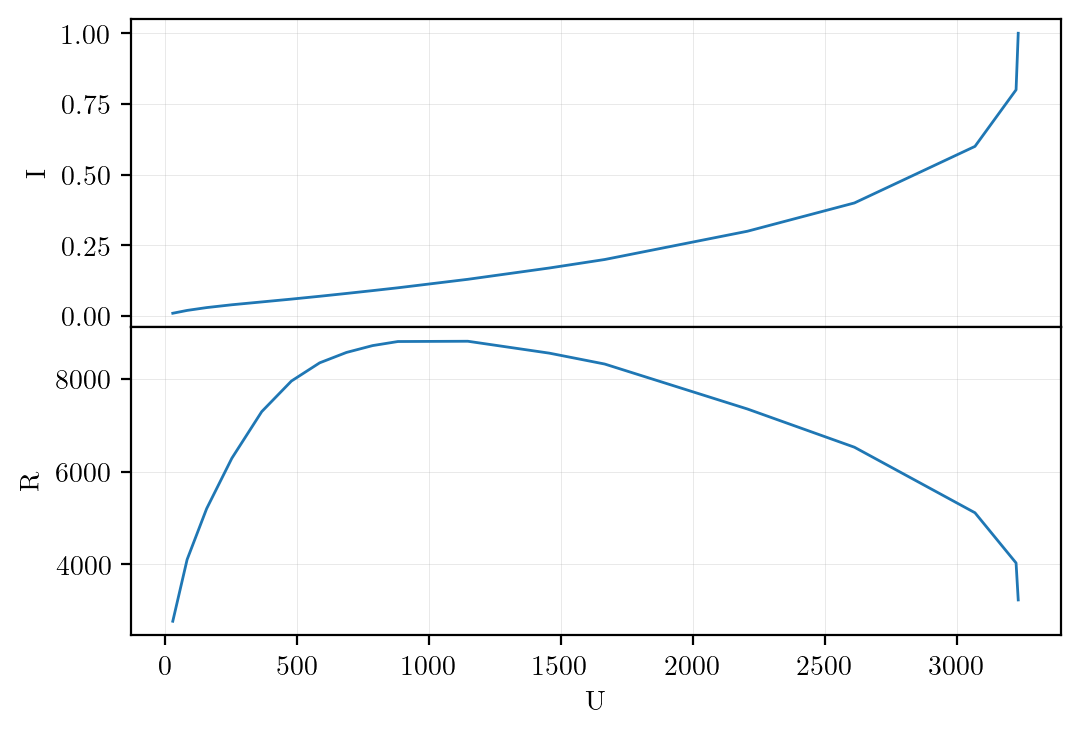

In [16]:
totzeit.plot_all();

# Physical values

In [17]:
x = lab.value("1.4(1) m")
print(x)
t = lab.value("2.0(3)e-3s")
print(t)
v = lab.value("x / t", x=x, t=t)
print(v)
y = lab.value("cos(x)", x=x)
print(y)

(1.4 +/- 0.1)m
(0.0020 +/- 0.0004)s
700 +/- 120
0.170 +/- 0.099


# Problem: Long parameter list
Example without this module:

In [18]:
def H(x, p, m, omega, hbar):
    return p**2 / (2 * m) + m * omega**2 * x**2 / 2

def H_diff(x0, p0, x1, p1, m, omega, hbar):
    return H(x1, p1, m, omega, hbar) - H(x0, p0, m, omega, hbar)

def calc_H_diff():
    m = 1
    omega = 42
    hbar = 1
    return H_diff(0, 0, 1, 1, m, omega, hbar)

print(calc_H_diff())

882.5


With this module:

In [19]:
x, p, m, omega, hbar = lab.vars("x p m omega hbar", (float, 1))

H = lab.Computed("H", p ** 2 / (2 * m) + m * omega ** 2 * x ** 2 / 2)

data = lab.ListData([
    {m: 1, omega: 42, hbar: 1},
]).child([
    {x: 0, p: 0},
    {x: 1, p: 1},
])

H_diff = lab.FunctionComputed("H_diff", lambda record: record[H], float)

print(H_diff.get_dependencies())

print(H_diff(data.to_record()))



[]
1.0
